In [1]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 897.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.8 MB/s 

In [2]:
!pip install timm

In [3]:
from torchvision import transforms,models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import torch.nn as nn
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils

In [4]:
import kagglehub

path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/aptos2019


In [5]:
list_dir = os.listdir(path)
print(list_dir)

['val_images', 'train_images', 'valid.csv', 'test.csv', 'train_1.csv', 'test_images']


In [6]:
train_images=path+'/train_images'*2
train_labels=pd.read_csv(path+'/train_1.csv')
valid_images=path+'/val_images'*2
valid_labels=pd.read_csv(path+'/valid.csv')
test_images=path+'/test_images'*2
test_labels=pd.read_csv(path+'/test.csv')

In [7]:
combined_data=pd.concat([train_labels,valid_labels,test_labels]).reset_index(drop=True)

In [8]:
combined_data.head()

id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0

In [9]:
combined_data['diagnosis'].value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

In [10]:
combined_data.shape

(3662, 2)

<Axes: xlabel='diagnosis', ylabel='count'>

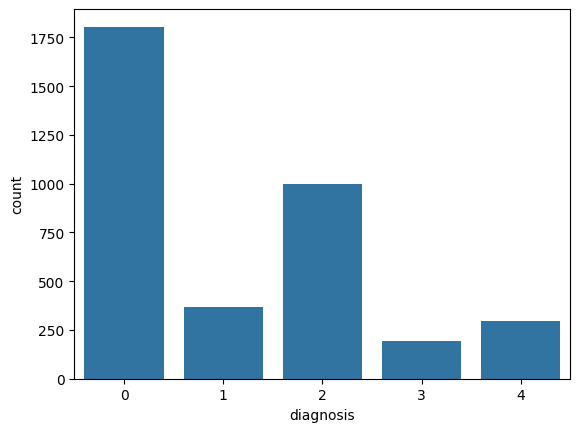

In [11]:
sns.countplot(combined_data,x='diagnosis')

In [12]:
image_dirs = [train_images,test_images,valid_images]
target_dir = "combined_images"
os.makedirs(target_dir, exist_ok=True)

for folder in image_dirs:
    for fname in os.listdir(folder):
        src = os.path.join(folder, fname)
        dst = os.path.join(target_dir, fname)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

In [13]:
target_size=500

In [14]:
data_downsampled=[]
for name,group in combined_data.groupby('diagnosis'):
  current_size=len(group)
  if current_size>target_size:
    data_downsampled.append(group.sample(target_size,random_state=42))
  else:
    data_downsampled.append(group)

downsampled_df=pd.concat(data_downsampled).reset_index(drop=True)
downsampled_df.head()

id_code  diagnosis
0  ef5155990874          0
1  24de56d433cd          0
2  81914ceb4e74          0
3  a1b28bcbce00          0
4  c365c598ad4e          0

In [15]:
downsampled_df['diagnosis'].value_counts()

diagnosis
0    500
2    500
1    370
4    295
3    193
Name: count, dtype: int64

In [16]:
train_APTOS_df,val_test_APTOS_df=train_test_split(downsampled_df,test_size=0.2,random_state=42,stratify=downsampled_df['diagnosis'])
val_APTOS_df,test_APTOS_df=train_test_split(val_test_APTOS_df,test_size=0.5,random_state=42,stratify=val_test_APTOS_df['diagnosis'])

In [17]:
path = kagglehub.dataset_download("mariaherrerot/ddrdataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ddrdataset


In [18]:
list_dir = os.listdir(path)
images_path=os.path.join(path,list_dir[1],list_dir[1])
labels_path=os.path.join(path,list_dir[0])
print(images_path)
print(labels_path)

/kaggle/input/ddrdataset/DR_grading/DR_grading
/kaggle/input/ddrdataset/DR_grading.csv


In [19]:
labels_df=pd.read_csv(labels_path)
labels_df.head()

id_code  diagnosis
0  20170413102628830.jpg          0
1  20170413111955404.jpg          0
2  20170413112015395.jpg          0
3  20170413112017305.jpg          0
4  20170413112528859.jpg          0

<Axes: xlabel='diagnosis', ylabel='count'>

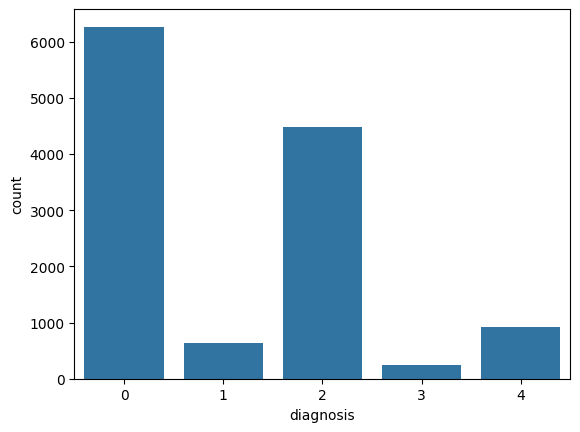

In [20]:
sns.countplot(x='diagnosis',data=labels_df)

In [21]:
labels_df['diagnosis'].value_counts()

diagnosis
0    6266
2    4477
4     913
1     630
3     236
Name: count, dtype: int64

In [22]:
size=800

In [23]:
new_data=[]
for name,group in labels_df.groupby('diagnosis'):
  targ_size=size-downsampled_df[downsampled_df['diagnosis']==name].shape[0]
  print(targ_size)
  if targ_size>0 :
    if targ_size>len(group):
      new_data.append(group)
    else:
      new_data.append(group.sample(targ_size,random_state=42))


300
430
300
607
505


In [24]:
collect_data=pd.concat(new_data).reset_index(drop=True)
collect_data.head()

id_code  diagnosis
0  20170220085833145.jpg          0
1  20170329074906288.jpg          0
2       007-1981-100.jpg          0
3       007-0795-000.jpg          0
4  20170226223624346.jpg          0

In [25]:
train_DDR_df,val_test_DDR_df=train_test_split(collect_data,test_size=0.2,random_state=42,stratify=collect_data['diagnosis'])
val_DDR_df,test_DDR_df=train_test_split(val_test_DDR_df,test_size=0.5,random_state=42,stratify=val_test_DDR_df['diagnosis'])

In [26]:
for image in os.listdir(images_path):
  if image in collect_data['id_code'].values:
    src=os.path.join(images_path,image)
    dst=os.path.join(target_dir,image)
    if not os.path.exists(dst):
      shutil.copy2(src,dst)

In [27]:
train_df=pd.concat([train_APTOS_df,train_DDR_df]).reset_index(drop=True)
val_df=pd.concat([val_APTOS_df,val_DDR_df]).reset_index(drop=True)
test_df=pd.concat([test_APTOS_df,test_DDR_df]).reset_index(drop=True)

In [28]:
train_df['diagnosis'].value_counts()

diagnosis
1    640
0    640
2    640
4    640
3    342
Name: count, dtype: int64

In [29]:
class_map = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

In [30]:
def reshape_transform(tensor):
    # Input: [B, H, W, C] → Output: [B, C, H, W]
    return tensor.permute(0, 3, 1, 2)


In [34]:
def crop_image_from_gray(img, tol=5):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # Image is too dark so that we crop out everything
            return img  # Return original image
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def apply_clahe_rgb(image):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        return  merged


def preprocessing(image_path, image_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = apply_clahe_rgb(image)
    image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
    image = cv2.resize(image, image_size, interpolation=cv2.INTER_CUBIC)

    original_image = image.astype(np.float32) / 255.0

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    input_tensor = transform(image).unsqueeze(0)
    return original_image, input_tensor


def apply_gradcam(model,image_path,target_layer,device,image_size=(224,224),show=True):
    original_image,input_tensor=preprocessing(image_path,image_size)
    input_tensor=input_tensor.to(device)
    model=model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        class_idx = torch.argmax(outputs, dim=1).item()
    cam=GradCAM(model=model,target_layers=[target_layer],reshape_transform=reshape_transform)
    targets = None if class_idx is None else [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=None if class_idx is None else targets)[0]
    result = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)
    if show:
        plt.imshow(result)
        plt.axis("off")
        plt.title(f"Class {class_map[class_idx]}")
        plt.show()

    return original_image,result,class_map[class_idx]

In [37]:
def infer(image_path):
  num_classes=5
  ''' weights = models.MobileNet_V2_Weights.DEFAULT
  model = models.mobilenet_v2(weights=weights)
  model.classifier[1]=nn.Linear(model.last_channel,num_classes)'''
  model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=5)
  model.load_state_dict(torch.load("/content/swin_transformer (3).pth", map_location=torch.device('cpu')))
  target_layer= model.layers[-1].blocks[-1].norm1
  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  original_image,image,preicted_class=apply_gradcam(
      model=model,
      image_path=image_path,
      target_layer=target_layer,
      device=device,
      image_size=(224, 224),
      show=False
  )
  return original_image,image,preicted_class

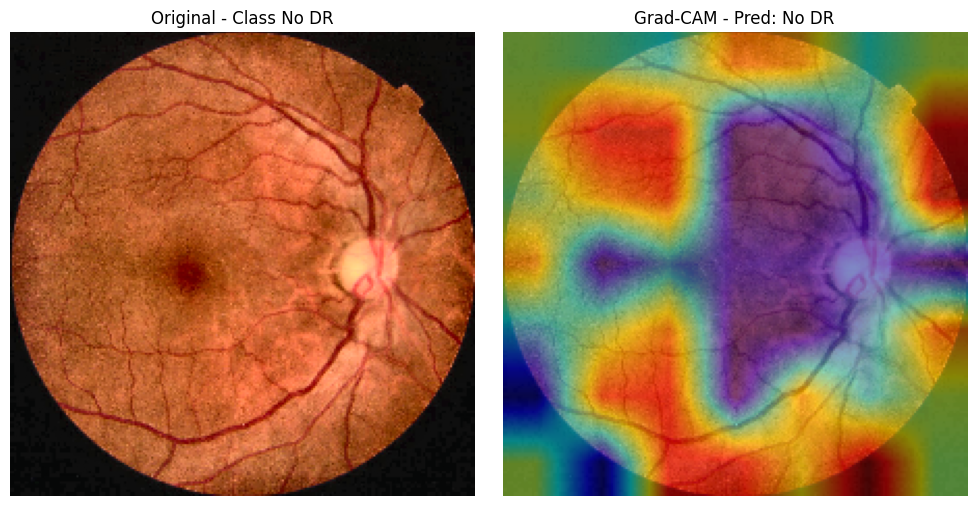

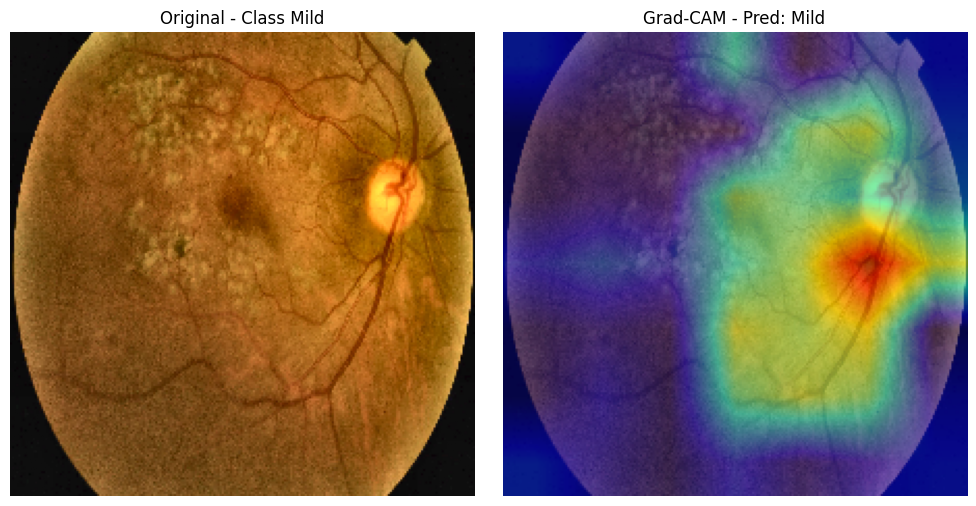

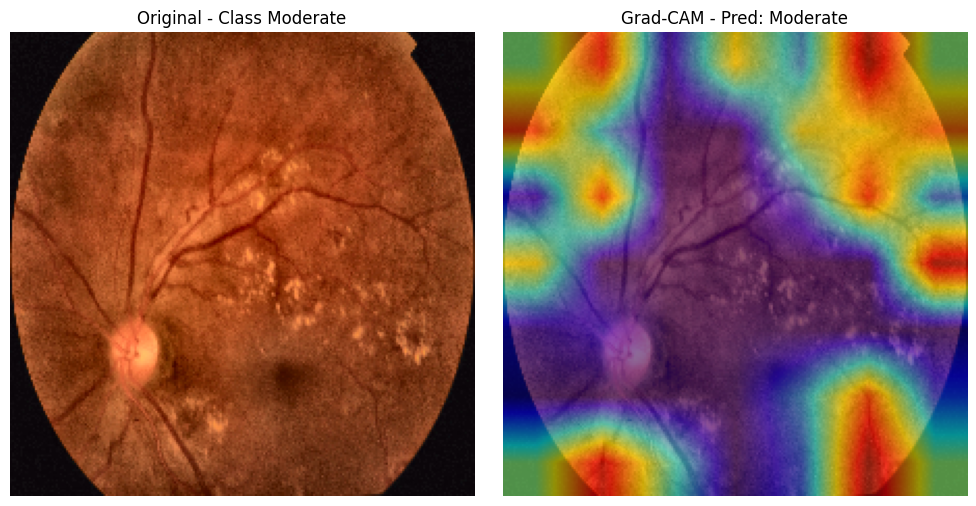

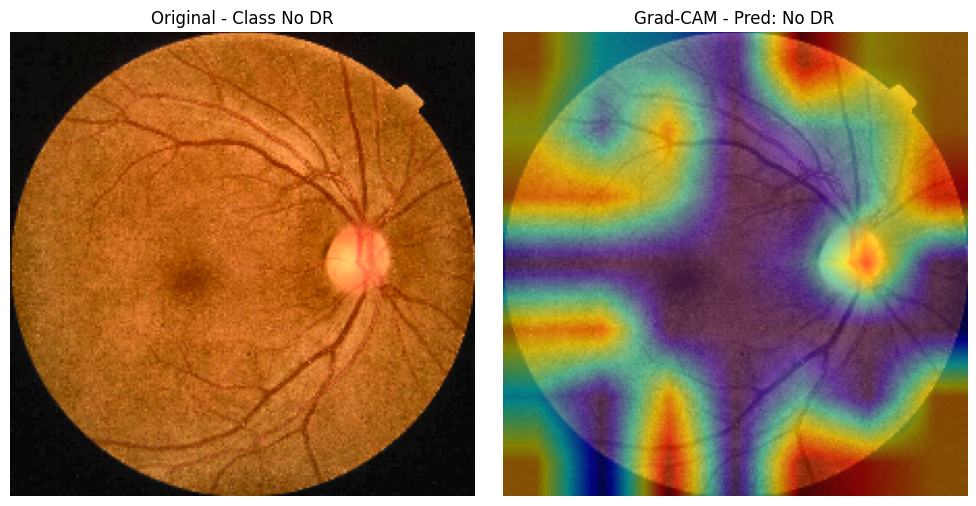

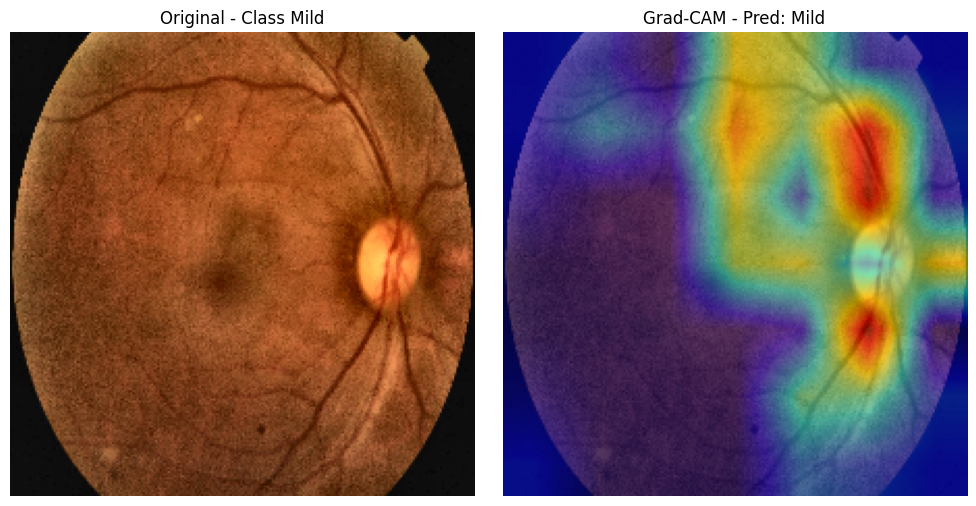

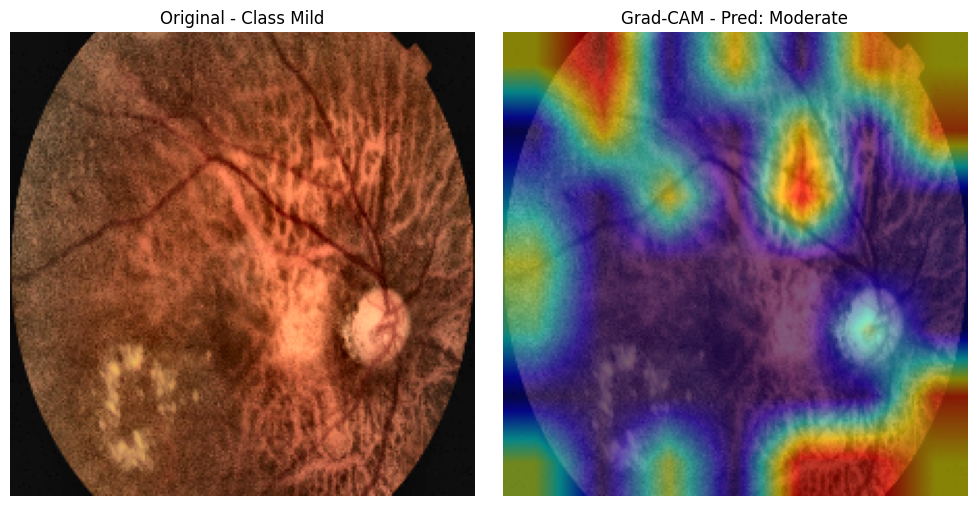

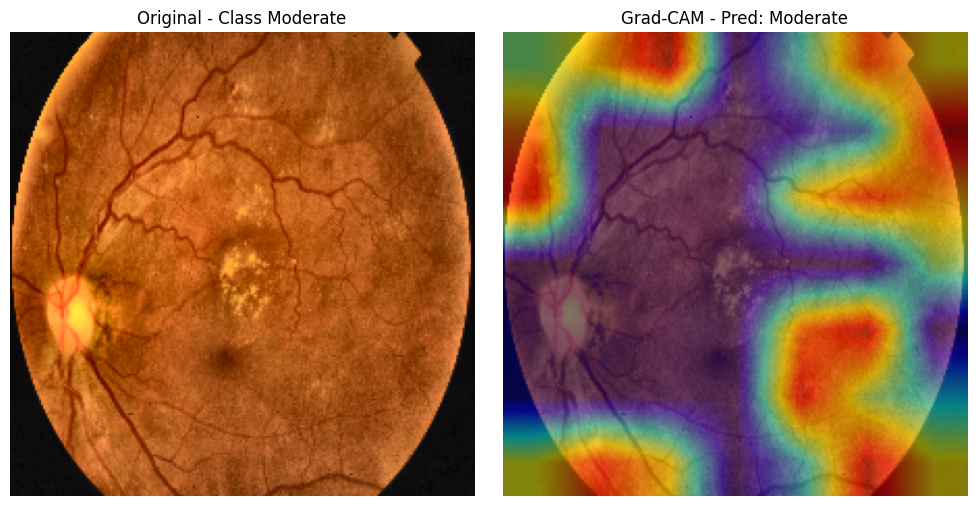

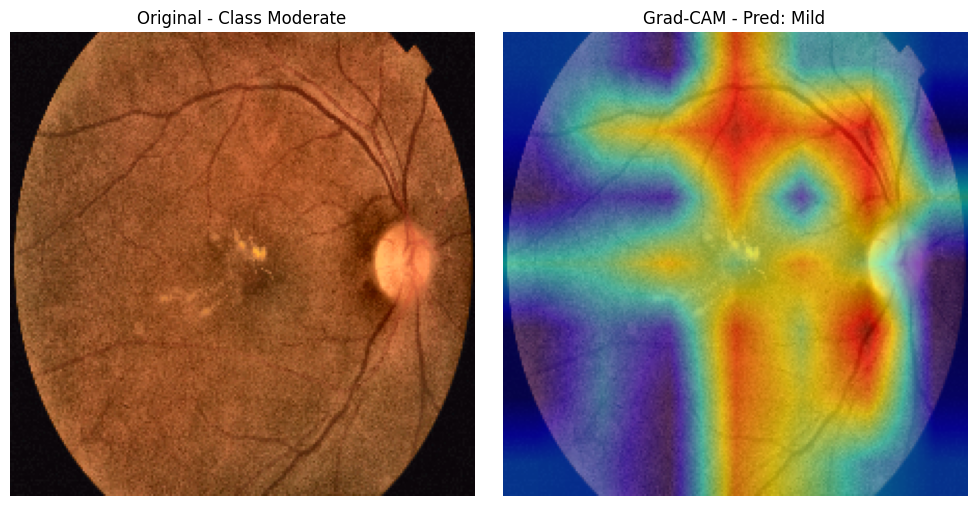

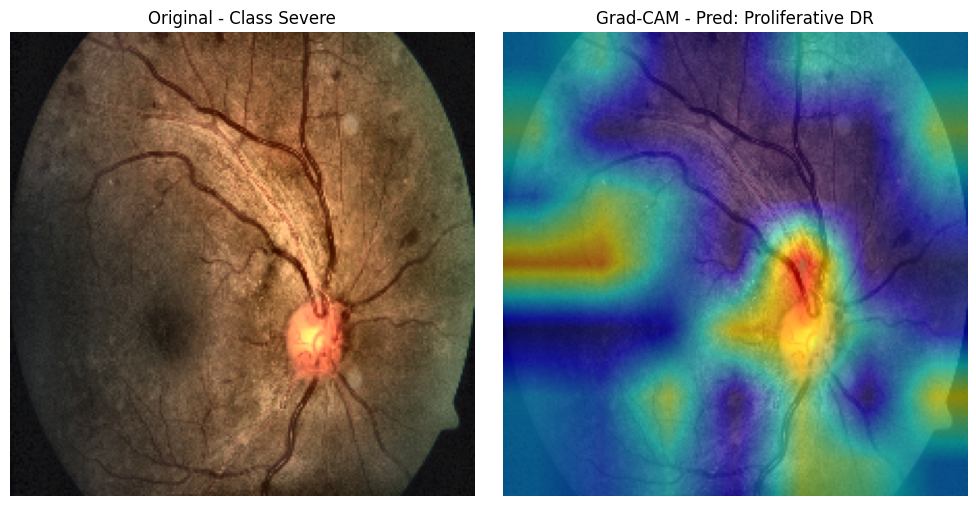

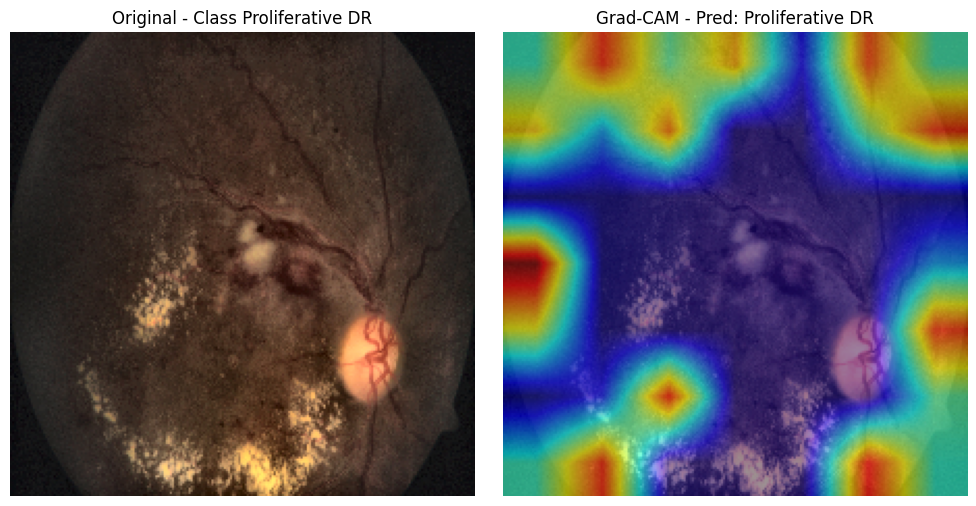

In [38]:
num_images=10
shows=0
for row in test_df.iterrows():
  image_name=row[1]['id_code']
  if '.' not in image_name:
      image_name=image_name+'.png'
  image_path=os.path.join(target_dir,image_name)
  actual_class_name=class_map[row[1]['diagnosis']]
  original,image,predicted_class_name=infer(image_path)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(original)
  axs[0].set_title(f"Original - Class {actual_class_name}")
  axs[0].axis('off')

  axs[1].imshow(image)
  axs[1].set_title(f"Grad-CAM - Pred: {predicted_class_name}")
  axs[1].axis('off')
  plt.tight_layout()
  plt.show()
  shows+=1
  if shows==num_images:
    break